In [1]:
from src.dl.inference.inferer import Inferer
import src.dl.lightning as lightning
from src.data import PannukeDataModule, ConsepDataModule

# Running Inference

## Param info of the Inferer class

- `stride_size` has a big impact on results. The smaller it is, the better the accuracy. However, small size results in increased memory footprint and running times
- `apply_weights=True` results in giving less weight on the tile boundaries during forward passes preventing boundary artifacts in the predictions. Used only for the auxilliary branch predictions because this is where the boundary effects affect the most (especially in horizontal and vertical gradient predictions)
- By tweaking `*batch_size` and `loader_num_workers` params, you can boost the inference performance depending on your machine. Hitting the sweetspot requires a few runs and a good knowledge of your machine specs.
- If your `in_dir` contains hundreds of images, use `n_images={int}` to refresh memory after every `n_images` are processed. This is needed because the Inferer class typically saves all the intermediate results in memory to be able to perform benchmarking etc. However, if you just need to do inference for a big number of images and no need for benchmarking, this will help.
- If you want to segment a wsi which contains many redundant tissue sections you can set `auto_range=True`. However, this only works if your `in_dir` contains images that are extracted from the same wsi and contain x- and y-coordinates encoded in their filenames. This will filter out only the tile files that are contained in the first tissue section of the wsi. 

In [2]:
# Initialize the inferer
in_dir = "/path/to/images/"
gt_dir = None # This is optional. Can be None
exp_name = "panoptic" # name of the experiment (directory)
exp_version = "effnetv2" # name of the experiment version (sub directory inside the experiment dir)
lightning_model = lightning.SegModel.from_experiment(name=exp_name, version=exp_version)

inferer = Inferer(
    lightning_model,
    in_data_dir=in_dir,
    gt_mask_dir=gt_dir,
    patch_size=(256, 256),
    stride_size=80,
    fn_pattern="*",
    model_weights="last",
    apply_weights=True,
    post_proc_method="cellpose",
    loader_batch_size=1,
    loader_num_workers=1,
    model_batch_size=16,
    auto_range=True,
    n_images=32
)

In [3]:
area_classes = {
    "background": 0,
    "areastroma": 1,
    "area_cin": 2,
    "areasquam": 3,
    "areagland": 4,
}

cell_classes = {
    "background": 0,
    "neoplastic": 1,
    "inflammatory": 2,
    "connective": 3,
    "dead": 4,
    "glandular_epithel": 5,
    "squamous_epithel": 6
}

result_dir = "/path/to/results/geojson"

inferer.run_inference(
    save_dir=result_dir,
    fformat="geojson",
    offsets=True,
    classes_sem=area_classes,
    classes_type=cell_classes
)

Post-processing: 100%|██████████| 24/24 [00:33<00:00,  1.39s/it]


# Plotting the tile predictions

- You can plot the intermediate results of the segmentation model in the cell below.
- This works only if `n_images=None` in the Inferer class. Otherwise the intermediate results are cleared from the memory.

In [ ]:
# import matplotlib.pyplot as plt
# from skimage.color import label2rgb
# from src.utils import FileHandler
# from pathlib import Path
# from src.utils import draw_thing_contours, draw_stuff_contours, label_sem_map,

# ix = 5
# keys = list(inferer.soft_insts.keys())
# key = keys[ix]
# img = FileHandler.read_img([f for f in sorted(Path(inferer.in_data_dir).glob("*")) if key in f.name][0])
# areas = draw_stuff_contours(label_sem_map(inferer.sem_maps[key]), img, inferer.sem_maps[key], classes=area_classes, thickness=5, fill_contours=True)
# everything = draw_thing_contours(inferer.inst_maps[key], areas, inferer.type_maps[key], classes=cell_classes)

# fig, ax = plt.subplots(2, 2, figsize=(40, 40))
# ax = ax.flatten()
# ax[0].imshow(label2rgb(inferer.sem_maps[key], bg_label=0))
# ax[1].imshow(label2rgb(inferer.type_maps[key], bg_label=0))
# ax[2].imshow(img)
# ax[3].imshow(everything)
# # ax[2].imshow(label2rgb(FileHandler.read_mask([f for f in inferer.gt_mask_dir if key in f.name][0], "inst_map"), bg_label=0))
# # ax[3].imshow(label2rgb(FileHandler.read_mask([f for f in inferer.gt_mask_dir if key in f.name][0], "type_map"), bg_label=0))

# Merging results

- If you saved the result predictions to geojson format and all the input tiles are adjascent to each other (e.g. extracted from a WSI), you can merge all the tiles together to form a QuPath readable geojson file.
- Only requirement for merging the tiles is that the x- and -y coordinates are encoded in the filenames of the images in `in_dir`
- You can plot the merged results in the second cell below this to check if everything went correctly.


In [2]:
from src.utils import CellMerger, AreaMerger, GSONTile

# Merge cell annotations
in_dir_cells = f"{result_dir}/cells"
fname_cells = f"{result_dir}/my_wsi_cells.json"

c = CellMerger(in_dir=in_dir_cells)
c.merge(fname=fname_cells)

In [11]:
# If the netowork outputs area predictions u can merge them too. If not, comment this out
in_dir_areas = f"{result_dir}/areas"
fname_areas = f"{result_dir}/my_wsi_areas.json"

a = AreaMerger(in_dir=in_dir_areas)
a.merge(fname=fname_areas)

<AxesSubplot:>

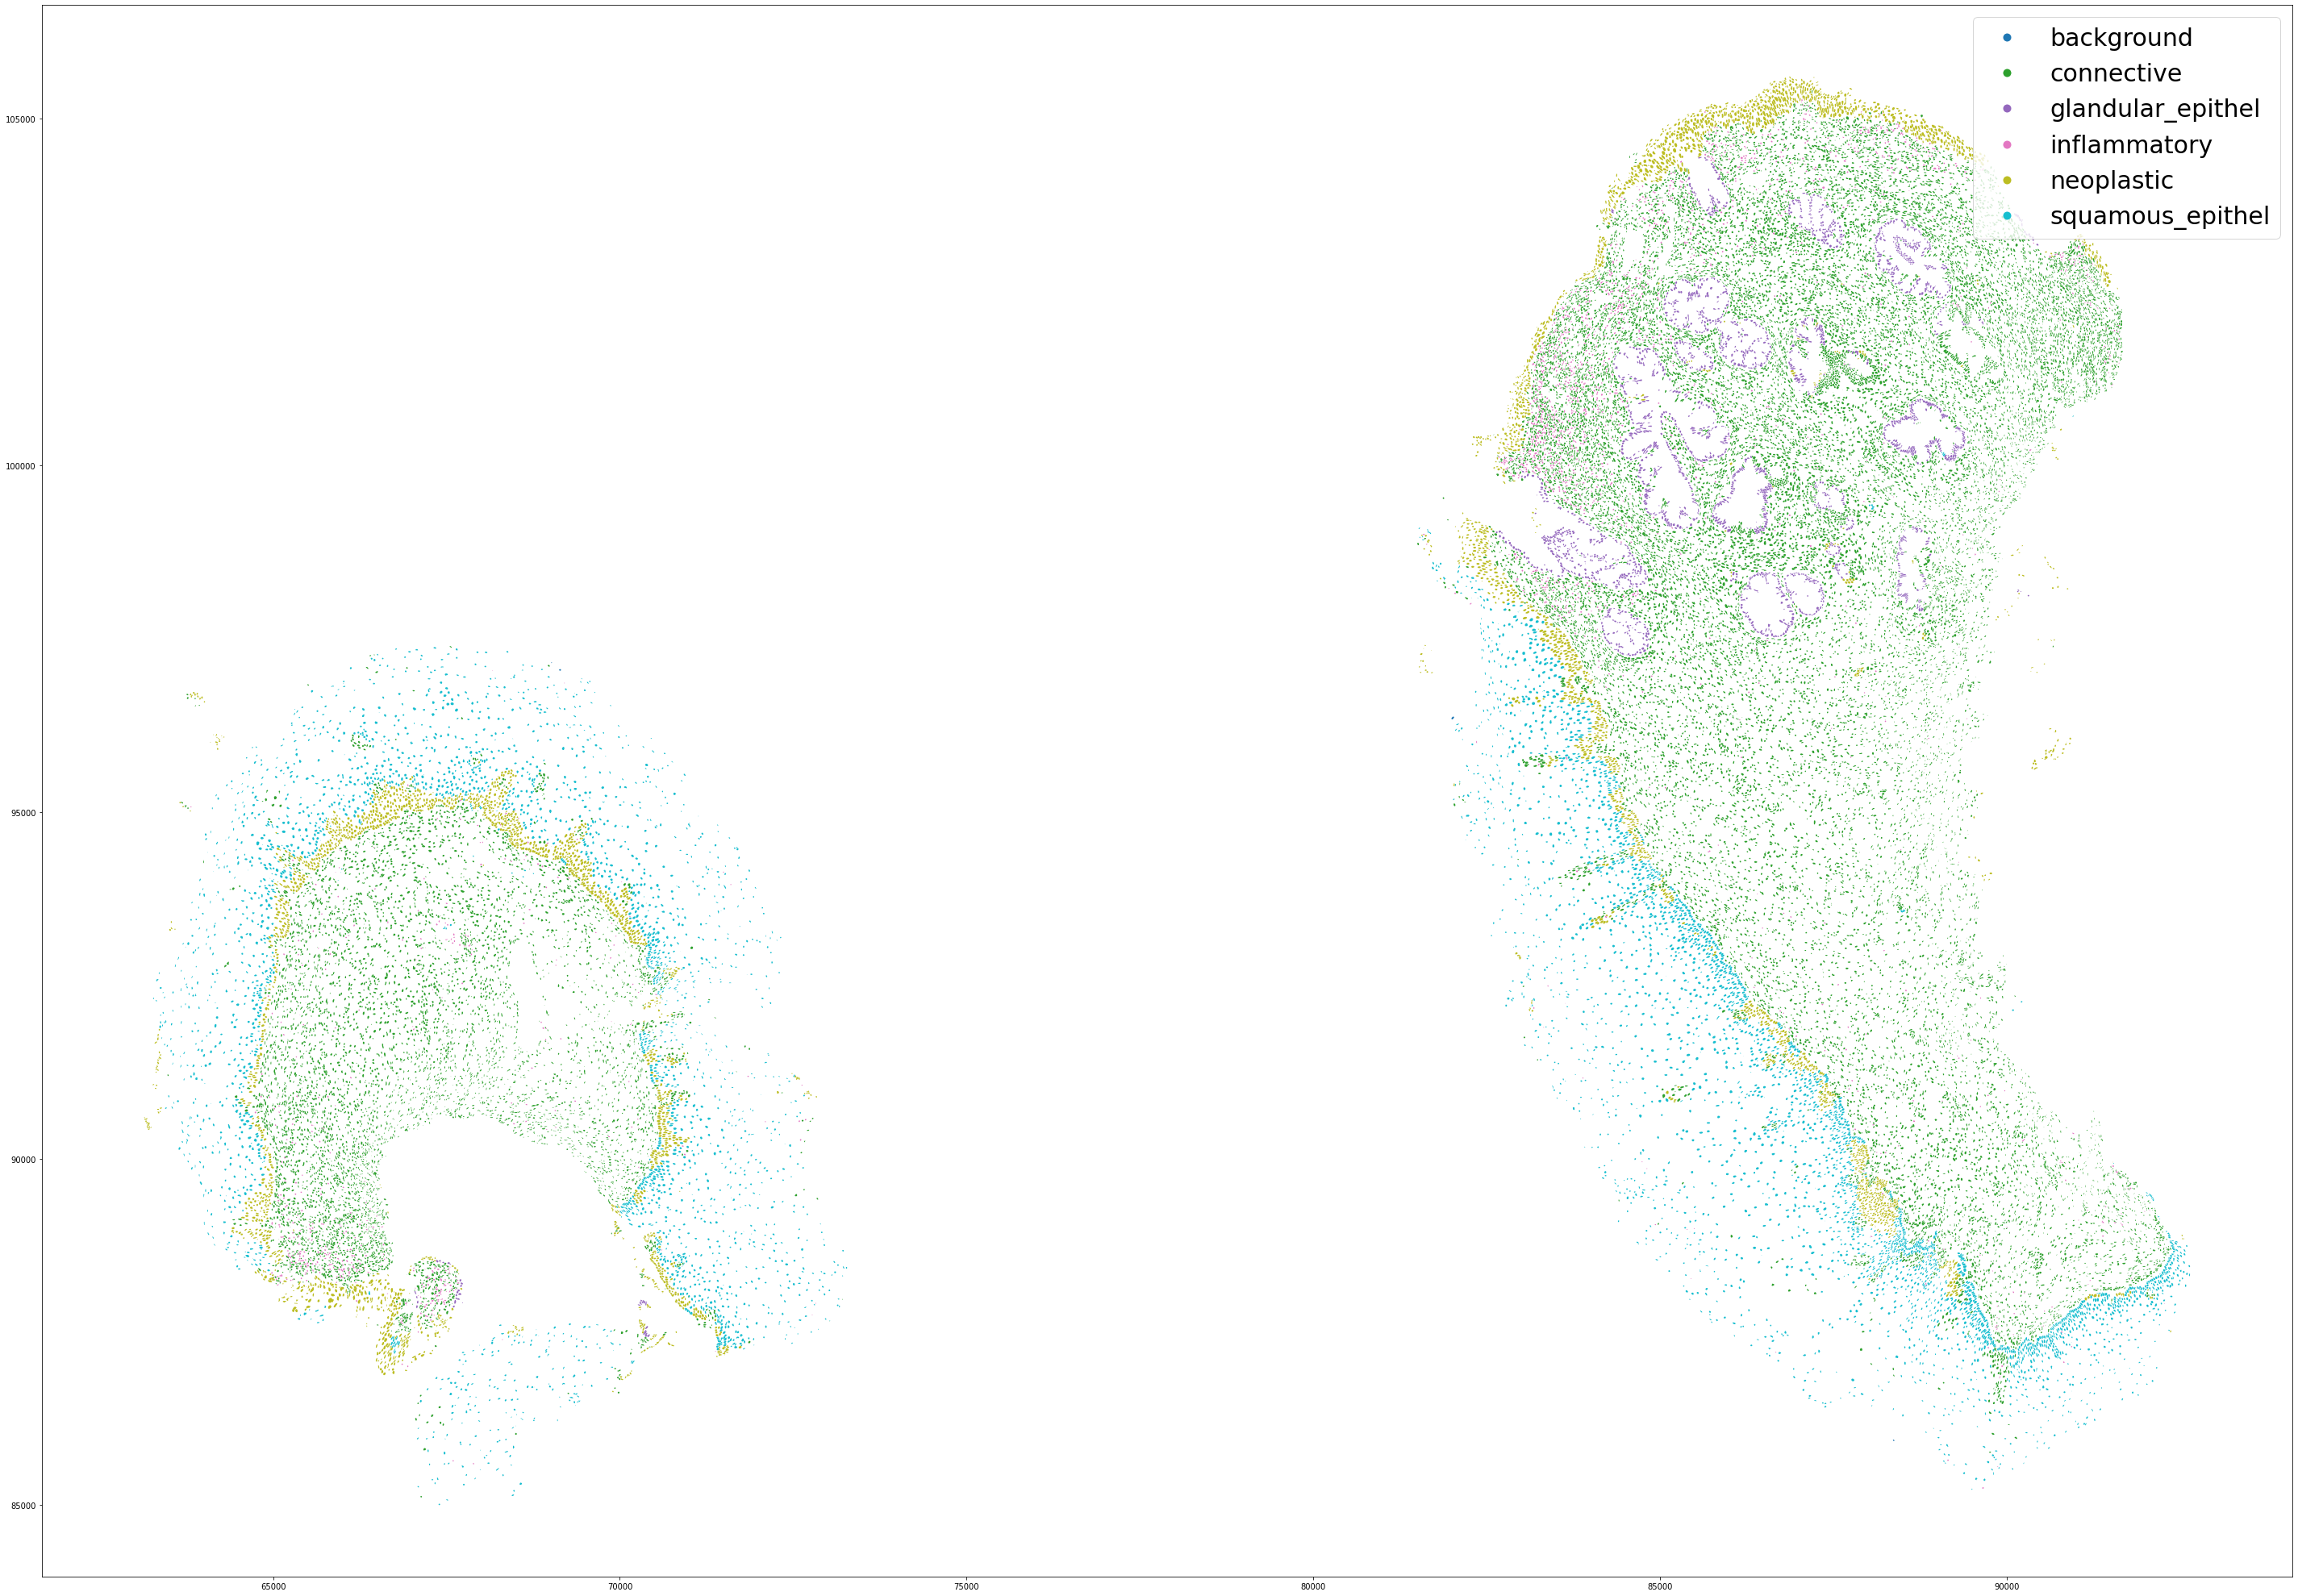

In [8]:
# Plot the results
cells = GSONTile(fname_cells, xmin=0, ymin=0)
cells.gdf.plot("class_name", figsize=(50, 60), categorical=True, legend=True, legend_kwds={"fontsize":30})

<AxesSubplot:>

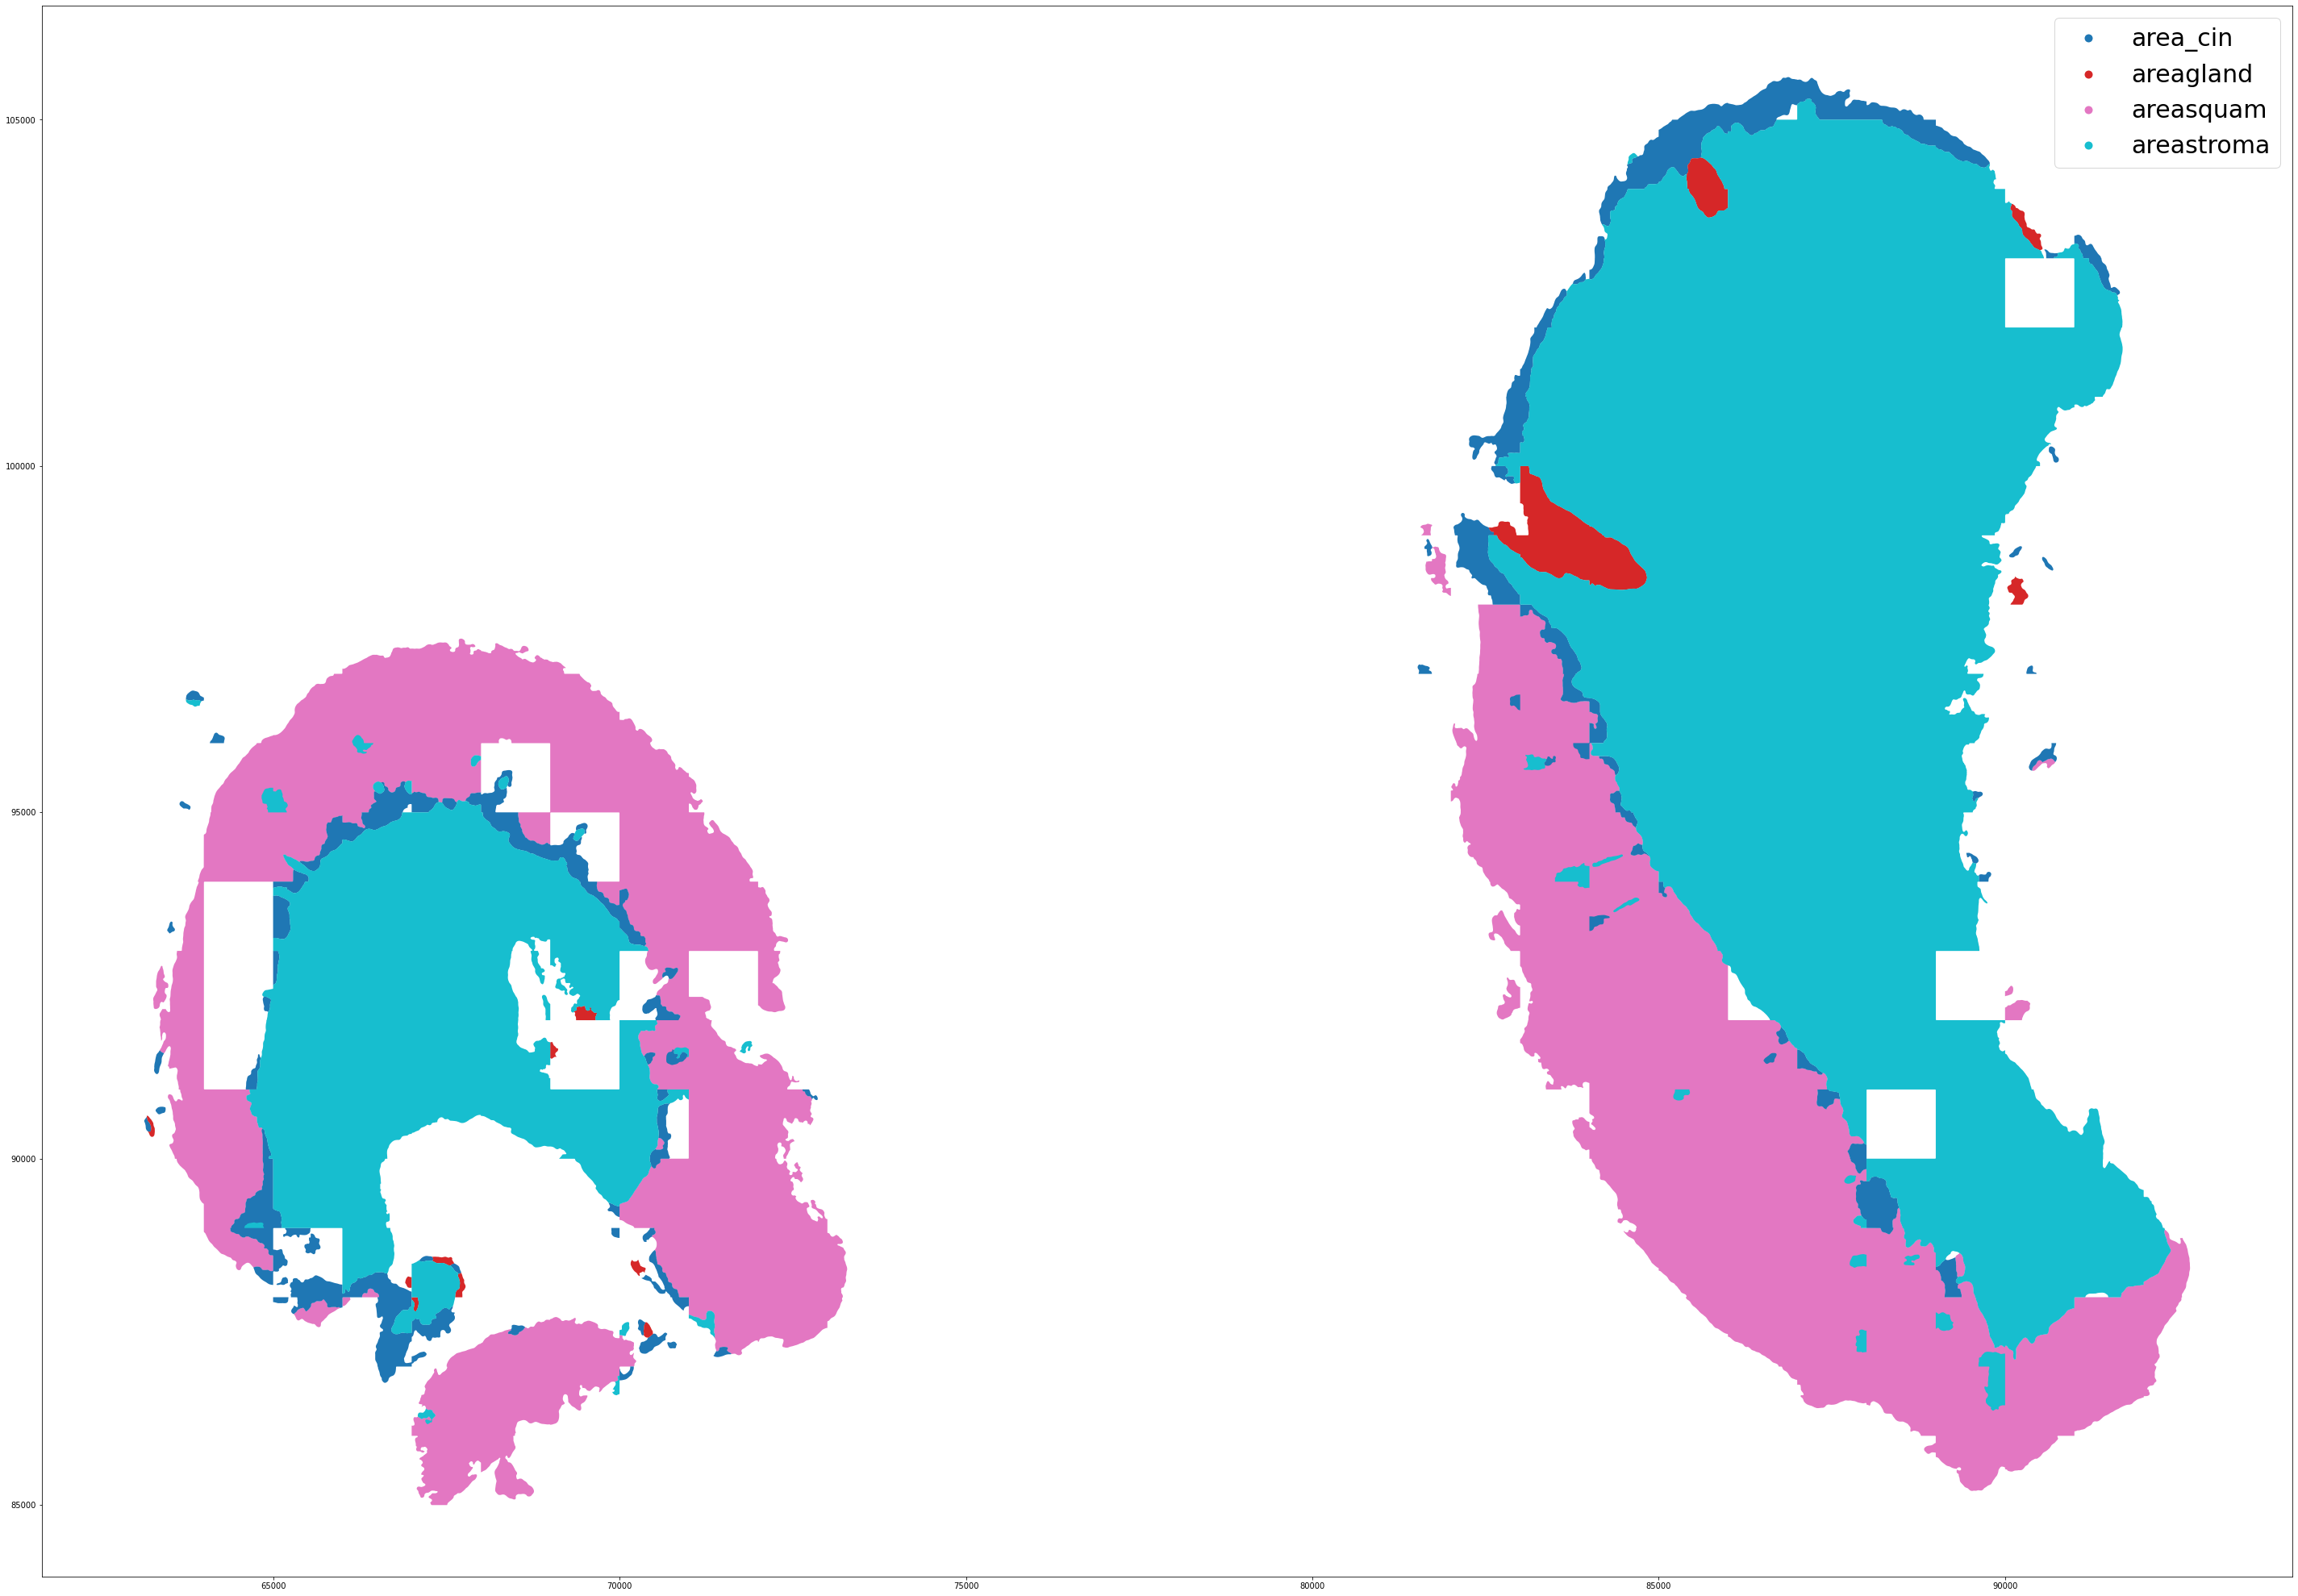

In [10]:
areas = GSONTile(fname_areas, xmin=0, ymin=0)
areas.gdf.plot("class_name", figsize=(50, 60), categorical=True, legend=True, legend_kwds={"fontsize":30})

# Running Benchmarking

- Only works if `gt_mask_dir` is provided in the Inferer class.
- The first cell below this one runs binary metrics i.e. segmentation metrics for all cells.
- The second cell below this one runs metrics per cell type.

In [ ]:
pattern_list = None
binary_scores = inferer.benchmark_insts(pattern_list=pattern_list, file_prefix=f"{exp_name}_{exp_version}")
binary_scores

In [ ]:
pattern_list = None
type_scores = inferer.benchmark_types(
    classes=PannukeDataModule.get_classes(),
    pattern_list=pattern_list, 
    file_prefix=f"{exp_version}"
)
type_scores = type_scores[type_scores.index.str.contains("avg")]
type_scores